## CCNSS 2018 module 2
# Tutorial 2 - Model fitting and model comparison

*Please execute the cells bellow to initialize the notebook environment*

In [1]:
!if [ ! -f ddm_tutorial1.py ]; then git clone https://github.com/ccnss/ccnss2018_students; \
                                    cp -f ccnss2018_students/module2/2_model_fitting_and_model_comparison/ddm_tutorial1.py ./; fi

In [2]:
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import time

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

---


## Objectives


In this notebook we'll look at *model fitting* using the Drift Diffusion Model (DDM) we developped in Tutorial 1. That is, we will attempt to recover the parameters that generated the data with the DDM. We will then have a look at *model comparison* and *model selection*.

Model fitting:

- Ordinary least squares (OLS)
- Likelihood, and Maximum Likelihood Estimation (MLE)
    - Grid search approximation
    - Gradient Descent optimisation

Model Comparison:

- Model Selection using:
    - Bayesian Information Criterion (BIC)
    - Akaike Information Criterion (AIC)

---


## Ordinary Least Squares (OLS) Regression

We have data pairs $(x_i,y_i)$ that we think are linearly related but we are not sure what the slope or intercept is that best characterizes this relationship. To find this, we fit the data with a linear model

\begin{align*} \hat{y}_i = \beta_1 x_i + \beta_0 \end{align*}

and estimate the best fitting parameters by minimizing the mean squared error (MSE). That is, we want to find the parameters $\beta_0$ and $\beta_1$ such that the line fits the data as best as possible. To do so, we will calculate the squared error (i.e. squared distance) between the line and the data-points, and choose the parameters that gives us the least error possible (i.e. the minimum error across all data points):

\begin{align*} \sum_i(y_i - \hat{y}_i)^2 = \sum_i (y_i-\beta_1 x_i-\beta_0)^2 \end{align*}

For the case of linear regression, there is actually an analytical solution:

\begin{align*} \beta_1 = \frac{cov(x,y)}{var(x)} \end{align*}

\begin{align*} \beta_0 = \bar{y} - \hat{\beta_1} x \end{align*}

but we will use a more general optimization library to start familiarizing ourselves with these tools.

** EXERCISE 1: OLS **

We will generate 100 data points with a linear relationship, and attempt to recover the parameters that generated the data.

** Instructions **
* Set the seed to 0 using `np.random`
* Generate N = 100 data pairs $(x_i,y_i)$ using a linear model with normally distributed noise $\epsilon = 1$ and your choice of slope $\beta_1=1$ and intercept $\beta_0=0.5$ parameters.
* Calculate the analytical estimate for the OLS regression. (hint: use sp.cov and sp.var)
* Write a function that returns the mean square error (MSE) for any parameter values.
* Use an optimization library to numerically find the parameters that minimize the MSE and compare these to the true parameters of the generative model (hint: you may want to use the function `sp.optimize.minimize(function,initial_guesses)`.
* Plot the data, as well as the anlytical and numerical OLS estimate


1.1259580136832137
Analytical B0: 0.5744796719087789 , B1: 1.1259580136832137
Optimization B0: 0.575153077426307 , B1: 1.1146984303994694


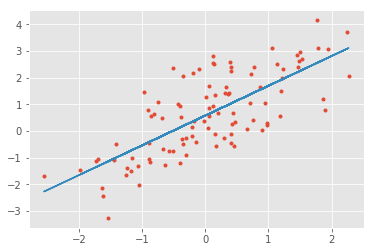

In [3]:
#insert your code here
np.random.seed(0)

# Generate the data
beta1 = 1
beta0 = 0.5
sigma = 1
xdata = np.random.normal(0,1,100)
eps   = np.random.normal(0,1, 100)
ydata = beta1*xdata + beta0 + eps

# Compute the analytical solutions
beta1_est = np.cov(xdata, ydata)[0,1]/np.var(xdata)
print(beta1_est)
beta0_est = np.mean(np.mean(ydata) - beta1_est*xdata)
print('Analytical B0: ' + str(beta0_est), ', B1: ' + str(beta1_est))

# Function that returns the MSE
def get_MSE(params):   
    
    return np.mean((ydata - (xdata*params[1] + params[0]))**2)

# Optimization (recovering the parameters)
initial_guess = np.array([0.5, 0.5])
res = sp.optimize.minimize(get_MSE, initial_guess)
print('Optimization B0: ' + str(res.x[0]), ', B1: ' + str(res.x[1]))

# Plot the data
plt.plot(xdata, ydata, '.')

plt.plot(xdata, xdata*res.x[1] + res.x[0])

**EXPECTED OUTPUT**

```
Analytical B0: 0.5744796719087789 , B1: 1.1259580136832137
Optimization B0: 0.5751530820156441 , B1: 1.1146984257201837
```
![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex1.png)

## Maximum Likelihood Estimation (MLE)

We can also fit the model to the data using Maximum Likelihood Estimation methods. To do this, we take the following generative model for the data:

\begin{align*} \hat{y}_i = \beta_1 x_i + \beta_0 + \epsilon \end{align*}

where $\epsilon\sim \mathcal{N}(\mu=0,\sigma^2)$ is a normally distributed random variable with mean 0 and variance $\sigma^2$ and $y\sim \mathcal{N}(\mu=(\beta_1 x+\beta_0),\sigma^2)$.

The probability distribution of $y$ given $x$ is then given by: 

\begin{eqnarray}
\\
p(y_i|x_i,\beta_1,\beta_0) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-(y_i-(\beta_1 x_i-\beta_0))^2/(2\sigma^2)\right]
\end{eqnarray}

For a pair $(x_i,y_i)$, the log likelihood of observation $y_i$ is 
\begin{eqnarray}
\log p(y_i|x_i,a,b)
= \log \left[\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-(y_i-(\beta_1 x_i-\beta_0))^2/(2\sigma^2)\right]\right] \\
= \log \left[\frac{1}{\sqrt{2\pi\sigma^2}}\right] -(y_i-(\beta_1 x_i-\beta_0))^2/(2\sigma^2)
\end{eqnarray}

That is: When $\epsilon$ is normally distributed, maximizing the total log likelihood of the data is equivalent to minimizing the mean squared error.


*** EXERCISE 2: MLE - Grid-Search ***

Using the generated 100 data points from EXERCISE 1, calculate the Likelihood of the data given the parameters. That is:

\begin{align*} p\left(Data_{y_i} \mid \beta_1,\beta_0 \right) \end{align*}

We will then extract the maximum of the log likelihood (or inversely, the minimum of the negative log likelihood). That is, the parameters that maximizes the chance of observing the data:

\begin{align*} p\left(\beta_1,\beta_0 \mid Data \right) = \arg \max \sum_{y_i} \log p\left(Data_{y_i} \mid \beta_1,\beta_0 \right)\end{align*}

*** Instructions ***

* Write a function that returns the total negative of the log likelihood for any parameter values.
* Search (loop) through parameter values ranging from -4 to 4 in increments of 0.01, calculate and store the negative log likelihood for each parameter value of the loop.
* Print the parameters found for $\beta_0$, and $\beta_1$ to the true parameters.
* Print the error between the true parameters and those found using optimization, and time the function took to compute the likelihood for all pairs of parameter values.
* Plot the log likelihood as a function of parameter values ($\beta_0$ and $\beta_1$) using a heatmap, and mark the value with lowest negative log likelihood (hint: you may want to use the function `plt.imshow()` or `plt.contourf()`)
    * (Optional) Alternatively you could try to make fancier 3D-plots using : `plt.plot_surface()`, or `plt.plot_wireframe()`)
* (Optional) Change the step-size (coarseness) of the grid, and see how this affects your parameter estimates.

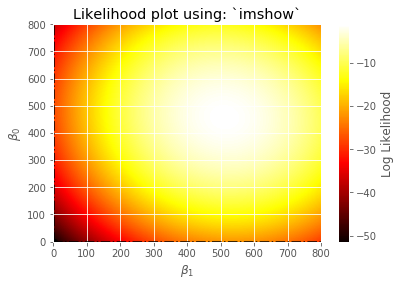

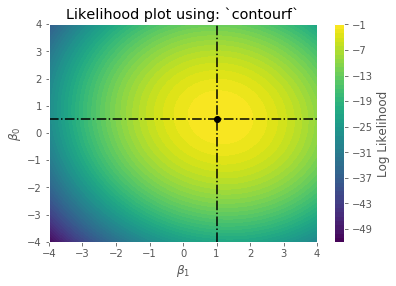

In [4]:
#insert your code here

# Function that returns the negative ll (nll)
def get_nll(params):
    b0 = params[0]
    b1 = params[1]
    
    return  -np.mean((ydata - (xdata*b1 + b0))**2)

# initialize your variables  
nll_values = np.zeros((len(np.arange(-4, 4, 0.01)), len(np.arange(-4, 4, 0.01))))
b0index = 0
b1index = 0
bestb0index = 0
bestb1index = 0
min_nll = 100

# Loop through grid and save nLL at each grid point
for b0 in np.arange(-4, 4, 0.01):
    b1index = 0
    for b1 in np.arange(-4, 4, 0.01):
        params = np.array([b0, b1])
        tnall = get_nll(params)
        nll_values[b0index, b1index] = tnall
        
        if tnall < min_nll:
            min_nll = tnall
            bestb0index = b0index
            bestb1index = b1index
        
        b1index += 1
    b0index += 1
    
#b0 = np.arange(-4, 4, 0.01)
#b1 = np.arange(-4, 4, 0.01)
#for i in range(len(np.arange(-4, 4, 0.01))):
#    for j in range(len(np.arange(-4, 4, 0.01))):
#        params = np.array([b0[i], b1[j]])
#        tnall = get_nll(params)
#        nll_values[i, j] = tnall

# Find indices of the grid which gives you the lowest nLL

# Print the estimated B0 & B1
#print('Estimated B0: '+ str(nll_values[bestb0index]) + ', estimated B1: ' +str(nll_values[bestb1index]) + ', estimated nLL: ' +str( min_nll) )
#print('Rounded Error B0: ' + str(round(   ,2)) + ' , rounded error B1: ' + str(round(   ,2)) + ' , Time taken : ' + str(round(   ,2)) + ' seconds')

# Plot using imshow()
plt.figure()
plt.title('Likelihood plot using: `imshow`')
#plt.imshow(nll_values, origin='lower',
#            cmap='hot', extent=extent, aspect='auto')
plt.imshow(nll_values, origin='lower',cmap='hot', aspect='auto')
plt.axvline(beta1,linestyle='-.',color='k')
plt.axhline(beta0,linestyle='-.',color='k')
plt.plot(beta1,beta0,'ok')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
plt.colorbar(label='Log Likelihood')

# Plot using contourf()
plt.figure()
plt.title('Likelihood plot using: `contourf`')     
plt.contourf(np.arange(-4, 4, 0.01),np.arange(-4, 4, 0.01),   nll_values , 50)
plt.axvline(beta1,linestyle='-.',color='k')
plt.axhline(beta0,linestyle='-.',color='k')
plt.plot(beta1,beta0,'ok')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
plt.colorbar(label='Log Likelihood')
plt.show()

*** Expected output ***

```
Estimated B0: 0.5799999999999024, estimated B1: 1.109999999999891, estimated nLL: -144.75460963988417
Rounded Error B0: 0.08 , rounded error B1: 0.11 , Time taken : 15.22 seconds
```

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex2_1.png)

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex2_2.png)

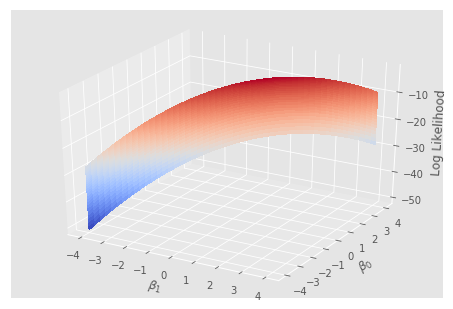

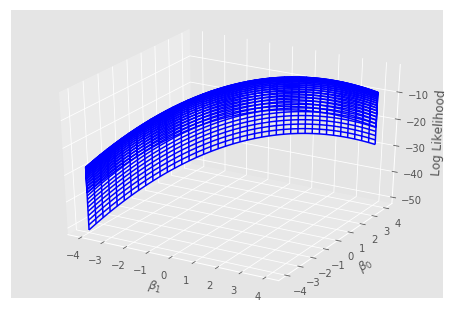

In [5]:
# --- OPTIONAL ---

# insert your code here to complete the plotting functions

# Plot using plot_surface()
fig = plt.figure()
plt.title('Likelihood plot using: `plot_surface`')
ax = Axes3D(fig)
surf = ax.plot_surface( np.arange(-4, 4, 0.01),np.arange(-4, 4, 0.01),   nll_values, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
ax.set_zlabel('Log Likelihood')

# Plot using wire_frame()
fig = plt.figure()
plt.title('Likelihood plot using: `contourf`')
ax = Axes3D(fig)
ax.plot_wireframe(np.arange(-4, 4, 0.01),np.arange(-4, 4, 0.01),   nll_values, color='blue', rstride=20, cstride=20)
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
ax.set_zlabel('Log Likelihood')
plt.show()

*** (Optional) EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex2_3.png)

*** EXERCISE 3: MLE - Optimization (Gradient Descent) ***

Instead of looping through the combination of all the parameter values in a loop. We will be using gradient descent (i.e. 'optimization' methods), to extract the maximum of the log likelihood (or inversely, the minimum of the negative log likelihood). That is, the parameters that maximizes the chance of observing the data:

\begin{align*} p\left(\beta_1,\beta_0 \mid Data \right) = \arg \max \sum_{y_i} \log p\left(Data_{y_i} \mid \beta_1,\beta_0 \right)\end{align*}

Intuitively, you can think of gradient descent optimization as follows: 
The optimization algorithm calculates the slope (i.e. derivative) of a function at a given point. In our case, we want to maximize the likelihood (i.e. find the top of the log-likelihood 'hill'). That is, the optimization function will calculates the gradient (derivative) of the log-likelihood given the parameter values, and 'ascend' the likelihood function (or 'descend' the negative log-likelihood) until it finds a derivative of 0 (it found a minima or maxima, up until convergence to some threshold)

*** Instructions ***

* Use an optimization library to numerically find the parameters that minimize the negative log likelihood (or equivalently, maximize the log likelihood of the data given the model). Tip: Use the function `minimize()` from the module `optimize` of Scipy. 
* Print the parameters found using the optimization function
* Print the error between the true parameters and those found using optimization, and time the function took to converge
* Compare the parameters found using optimization to those found with grid-search
* Compare the time it took to find the parameters with optimization vs. grid-search


In [6]:
# insert your code here

# Optimization (find parameters that minimize nll)
initial_guess = 
res = 

print('Estimated B0: '+ str(  ) + ', estimated B1: ' +str(  ) + ', estimated nLL: ' +str(   ) )
print('Rounded Error B0: ' + str(round(    ,2)) + ' , rounded error B1: ' + str(round(    ,2)) + ' , Time taken : ' + str(round(    ,8)) + ' seconds')
print(' ')
print('Grid-search took ' + str(   ) + ' times longer than using the `minimize` function')


SyntaxError: invalid syntax (<ipython-input-6-6fd1e53102b2>, line 4)

*** EXPECTED OUTPUT ***

```
Estimated B0: 0.5751530877738371, estimated B1: 1.1146984394529669, estimated nLL: 144.75244602999874
Rounded Error B0: 0.08 , rounded error B1: 0.11 , Time taken : 0.00580382 seconds
 
Grid-search took 2621.999671363431 times longer than using the `minimize` function
```

# Application: Fitting the DDM

Now that we have looked at model fitting for a simple case, we can try to fit the DDM to the data from last class in order to find the best fitting mean, noise and boundary parameters.

We will test our ability to recover the parameters of the model on simulated data for which we set the parameters.

Once we are convinced that we can recover the parameters on simulated data.

*** EXERCISE 4: Fit DDM to simulated data ***
    
*** Instructions ***

* Set your seed to 0
* Generate 5000 trials of simulated RT data using the constant bound DDM function ($\mu = 0.0015, \sigma = 0.05, B = 1$)
* Plot the simulated RT data using your plot function from yesterday

Tip: We will import a data simulation function `sim_DDM_constant()`, a plotting function `plot_rt_distribution()` and a function that computes the analytic DDM and returns the (RG) `analytic_ddm` from the module `ddm`. You can use this module or you can use your own based on the work from the last tutorial.

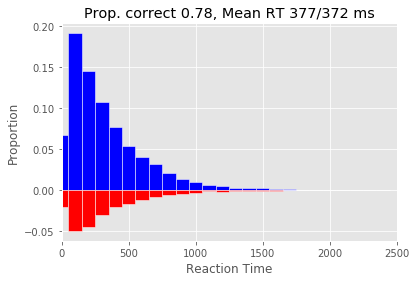

In [7]:
#insert code here
np.random.seed(0)

mu = 0.0015
sigma = 0.05
B = 1

import ddm_tutorial1 as ddm

trails = 5000
all_trail_t = []
all_trail_v = []
all_correct = []
all_rt = []
for i in range(trails):
    choice, correct, rt, dvTrace, tTrace = ddm.sim_DDM_constant(mu, sigma, B, seed=i)
    all_trail_t.append(tTrace)
    all_trail_v.append(dvTrace)
    all_correct.append(correct)
    all_rt.append(rt)
    
correct_rt = []
wrong_rt = []
for i in range(len(all_rt)):
    if all_correct[i]:
        correct_rt.append(all_rt[i])
    else:
        wrong_rt.append(all_rt[i])


ddm.plot_rt_distribution(correct_rt, wrong_rt, bins=None)

*** EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex4.png)

*** EXERCISE 5: Compute likelihood from analytic DDM ***

In this exercise we will calculate the likelihood given parameters for the Drift Diffusion Model.

*** Instructions ***

* Implement the calculation of the DDM negative log-likelihood by completing the function below.
* Use the function `analytic_ddm()` from the module `ddm_tutorial1` to calculate the log-likelihood for a correct trial where RT is $500ms$, $\mu=0.0015$ and $B=1$.
* What's the log-likelihood for an incorrect trial with otherwise identical parameters?
* What's the analytical log-likelihood of the decision-variable trajectory from the previous exercise?

In [8]:
def get_nll_ddm(mu, sigma, B, rts, corrects):
    '''
    Determines the negative loglikelihood of the analytical DDM
    
    Parameters
    ----------
    mu : float
        DDM drift rate
    sigma : float
        DDM standard deviation
    B : 
        DDM boundary
    rts : array_like of floats
        reaction times for which the likelihood will be evaluated
    corrects: array_like of bools, same length as rts
        indicates for each rt if it was a correct trial
        
    Returns
    -------
    nll : float
        negative log-likelihood
    '''
    # Evaluate the analytic ddm

    # init log-likelihood (LL)
    

    # For each RT determine the LL from the corresponding
    # correct or incorrect analytical RT proabability distribution
    # and sum LLs over occurrences of the RT
    
    # - correct trial RTs
    

    # - incorrect trial RTs
        
    # return negative LL
    dist_cor, dist_err = ddm.analytic_ddm(mu, sigma, B, rts, b_slope=0)
    print('***')
    print(dist_cor.shape)
    print(dist_err.shape)
    
    p1 = -np.sum(np.log(dist_cor[corrects]+0.0001))
    p2 = -np.sum(np.log(dist_cor[1-corrects]+0.0001))
    
    return p1 + p2

In [9]:
#insert code here
mu = 0.0015
sigma = 0.05
B = 1


all_rt = []
correctness = []
for i in range(200):
    choice, correct, rt, dvTrace, tTrace = ddm.sim_DDM_constant(mu, sigma, B, dt=1, tMax=500, seed=i)
    all_rt.append(rt)
    correctness.append(correct)
    
#print(all_rt)

get_nll_ddm(mu, sigma, B, np.array(all_rt), np.array(correctness))

200
200
***
(200,)
(200,)


2237.657895276777

*** Expected Output ***

```
Log-Likelihood using analytical DDM, correct trial, 500ms: -7.400167869285413
Log-Likelihood using analytical DDM, incorrect trial, 500ms: -8.600167869285412
Log-Likelihood using analytical DDM, using decision-variable trajectory: -36579.05972243618
```

*** EXERCISE 6: Fit DDM to simulated reaction time data ***

Once you are able to evaluate your likelihood function at various parameter values, it's time to fit the simulated data. The goal here is to pass the negative log likelihood to an optimizer that will find the parameters to minimize the total negative log likelihood.

Note that optimizers tend to work better when parameters have the same order of magnitude. Also, the optimization function that we are going to use, `sp.optimize.minimize()`, requires that all parameters that are optimized over are packed into a vector and that this vector is the first argument of the objective function.

- Execute the wrapper function below. It's exactly like the function `get_nll_ddm()`, except that it takes as first argument the vector $(1000 \mu,B)$.

Remember that this will mean rescaling the parameters returned by the optimizer in future exercises!

In [10]:
# parameters = (1000mu, B)
get_nll_ddm_wrapper = lambda parameters, sigma, rts, corrects: get_nll_ddm(parameters[0]/1000., sigma, parameters[1], rts, corrects)

*** Instructions ***

* Use the optimizer `minimize` on your negative log likelihood function to maximize the log likelihood of the simulated data. Again $\sigma$ will be fixed at 0.05. 
* Is the optimization succesful? If yes, you should see "message: 'Optimization terminated successfully.'" in the output. If not, consider using a bounded optimization (check out the bounds input to the function and use method 'SLSQP'). $\mu$ and $B$ should be positive.
* Compare the simulated data with the fitted distribution. To do so, use the analytic_ddm function with the fitted parameter value.

In [11]:
#insert your code here

x0 =     np.array([0.001, 1]) # Initial guess
bounds =  [[-1, 1], [-1, 1]]# Optimization bounds
sigma = 0.05  # always fixed

rts_sim = np.array(all_rt)
corrects_sim = np.array(correctness)


get_nll_ddm_wrapper(x0, sigma, rts_sim, corrects_sim)

# The lambda expression allows us the pass different datasets
res = sp.optimize.minimize(    get_nll_ddm_wrapper    , x0,
               args=(sigma, rts_sim, corrects_sim),
               method='SLSQP')#bounds=bounds
ll =   get_nll_ddm(res.x[0], sigma, res.x[0], np.array(all_rt), np.array(correctness))  # get neg log likelihood

print(res.message)
#print('Loglikelihood is :' + str(round(   ,2)))

# Plotting the simulated data
#bins = np.linspace(0,2500,51)
#plot_rt_distribution(rts_sim[corrects_sim==1], rts_sim[corrects_sim==0], bins)

# Plotting the analytical results
#teval = np.arange(0,bins[-1],1)[1:]
#mu =  # don't forget the scaling
#b =   


#dist_cor, dist_err = analytic_ddm(   ,  ,  , teval)

#plt.plot(teval, dist_cor*(bins[1]-bins[0]), color = 'blue')
#plt.plot(teval,-dist_err*(bins[1]-bins[0]), color = 'red')
#plt.show()

200
200
***
(200,)
(200,)
200
200
***
(200,)
(200,)
200
200
***
(200,)
(200,)
200
200
***
(200,)
(200,)
200
200
***
(200,)
(200,)
0


ValueError: max() arg is an empty sequence

*** Expected output ***

```
Optimization terminated successfully.
Loglikelihood is :-36565.58
```

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex6_2.png)

## Model Comparison

We will use the $BIC$ (Bayesian Information Criterion) to compare models:

\begin{align*} -2 \log p(M|y) \approx -2\ln(L) + k\ln(n) \equiv BIC \end{align*}

where 
                            * $M$ is the model under consideration, 
                            * $L$ the likelihood for model $M$,
                            * $y$ the observed data, 
                            * $k$ the number of free parameters, 
                            * $n$ the number of data points (observations)

and the approximation holds for large $n$.

The $BIC$ penalizes more complex models with more parameters. Specifically, in our context, the BIC penalizes the non-decision time model for its extra parameter.

Note that a lower BIC is better and in general a difference of BIC 10 or more is good evidence for the model with the lower BIC.

*** EXERCISE 7 : Calculating the BIC ***

We will compute the BIC for three models (one full model-- as done in previous exercise), one where we fix the $B=0.5$ to a constant, and one where $mu=0$ is fixed (you can think of this as a Null model)

*** Instructions ***

* Fit the models with Compare the BIC for the three models (you can constrain parameter values by restricting the bounds of parameters to be optimized)
* Which model has the smaller BIC (the smaller the better)?
* Plot the BICs for each model

In [ ]:
#insert code here

*** EXPECTED OUTPUT ***

```
BIC for models: 
Full Model BIC: 73148.1910964668
Restricted B Model BIC: 73303.0401588169
Restricted Mu Model BIC: 74322.5969652832
```

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/2_model_fitting_and_model_comparison/figures/expected_ex7_2.png)